# Test 5

* Magnetic field along the x axis (8mT).
* Ramp for 60s
* Evolution for 120s


In [60]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas
import pandas as pd

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

from auxiliary import getVerticesDict, getVerticesCount, getVerticesAverage, plotColloid, getPaintedFrame

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

# Running the simulations

In [31]:
def getSimulation():
    sp = ice.spins()

    # Initialize some parameters
    trapSep = 10*ureg.um
    particleRadius = 5*ureg.um
    totalTime = 180*ureg.s

    L = 30*ureg.um
    N = 10

    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

    particle = ice.particle(radius = particleRadius,
                susceptibility = 0.0576,
                diffusion = 0.125*ureg.um**2/ureg.s,
                temperature = 300*ureg.K,
                density = 1000*ureg.kg/ureg.m**3)

    trap = ice.trap(trap_sep = trapSep,
                height = 4*ureg.pN*ureg.nm,
                stiffness = 1e-3*ureg.pN/ureg.nm)

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = 0, 
                            susceptibility_spread = 0.1,
                            periodic = True)

        
    col.randomize()
    col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

    framespersec = 20*ureg.Hz;
    dt = 10*ureg.ms

    world = ice.world(
        field = 8*ureg.mT,
        temperature = 300*ureg.K,
        dipole_cutoff = 200*ureg.um)


    col.simulation(world,
                name = "test",
                include_timestamp = False,
                targetdir = r".",
                framerate = framespersec,
                timestep = dt,
                run_time = totalTime,
                output = ["x","y","z","mux","muy","muz"])

    # Field
    col.sim.field.fieldx = "v_Bmag*time/60e6*(time<60e6)+v_Bmag*(time>=60e6)"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = "0"

    col.run_simulation();

    col.load_simulation()

    return col

In [ ]:
runs = 10

for i in range(1,runs+1):
    print(f"===== Experiment number {i} =====")
    col = getSimulation()

    filename = f"trj{i}.csv"
    print(filename)
    col.trj.to_csv('../data/test5/trj/' + filename)
    print('Saved trj')
    
    filename = f"ctrj{i}.csv"
    print(filename)
    trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
    trj.to_csv('../data/test5/ctrj/' + filename)
    print('Saved centered trj')

# Getting vertices

In [ ]:
trjPath = "../data/test5/trj/"
ctrjPath = "../data/test5/ctrj/"
verticesPath = "../data/test5/vertices/"

# Get the number of realizations
_, _, files = next(os.walk(trjPath))
realizations = len(files)

for i in range(1,realizations+1):
    print("============================================================")
    print(f"Working on realization {i}")

    # Importing files
    trjFile = trjPath + f"trj{i}.csv"
    print(f"Opening " + trjFile)
    ctrjFile = ctrjPath + f"ctrj{i}.csv"
    print(f"Opening " + ctrjFile)
    trj_raw = trj = pd.read_csv(trjFile, index_col=[0,1])
    ctrj_raw = pd.read_csv(ctrjFile, index_col=[0,1])

    v = ice.vertices()
    frames = ctrj_raw.index.get_level_values("frame").unique()

    verticesFile = verticesPath + f"vertices{i}.csv"
    v.trj_to_vertices(ctrj_raw.loc[frames[::25]])

    print(f"Saving vertices to " + verticesFile)
    v.vertices.to_csv(verticesFile)

# Analysis

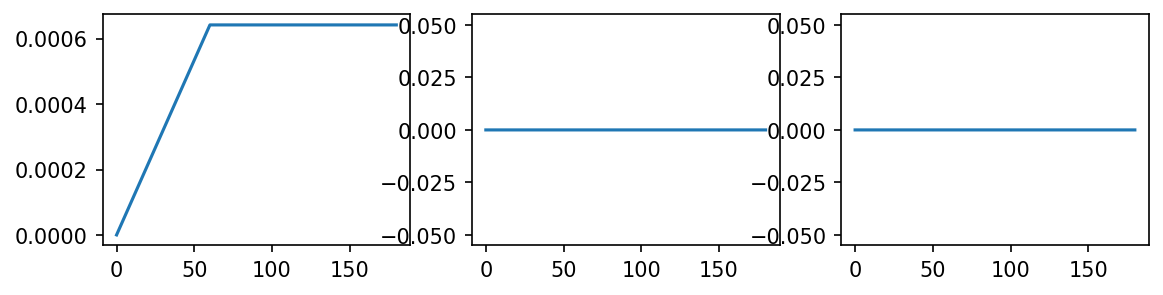

In [35]:
trj_raw = trj = pd.read_csv("../data/test5/trj/trj1.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/test5/ctrj/ctrj1.csv", index_col=[0,1])

fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax[0].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax[1].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax[2].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))

In [36]:
# Import and classify the vertices
verticesFolderPath = "../data/test5/vertices/"
vertices = getVerticesDict(verticesFolderPath)
vertices["10"]

x      y  coordination  charge            dx   dy type
frame vertex                                                            
0     3       120.0  270.0             4       0 -2.000000e+00 -2.0   IV
      4       270.0  270.0             4       4  0.000000e+00  0.0   VI
      5       270.0  240.0             4       0  0.000000e+00  0.0  III
      10      270.0  210.0             4       4  0.000000e+00  0.0   VI
      11      270.0  180.0             4      -2  1.224646e-16  2.0   II
...             ...    ...           ...     ...           ...  ...  ...
3575  94      240.0  210.0             4       0  2.000000e+00 -2.0   IV
      95      240.0   30.0             4       2  1.224646e-16  2.0    V
      96      240.0   60.0             4      -2  1.224646e-16  2.0   II
      97       30.0   60.0             4       4  0.000000e+00  0.0   VI
      98       60.0   60.0             4      -4  0.000000e+00  0.0    I

[11664 rows x 7 columns]

In [37]:
counts = getVerticesCount(vertices)
counts["10"]

number  fraction
frame type                  
0     I          3  0.037037
      II        23  0.283951
      III       14  0.172840
      IV        21  0.259259
      V         11  0.135802
...            ...       ...
3575  II        14  0.172840
      III        1  0.012346
      IV        14  0.172840
      V         15  0.185185
      VI        19  0.234568

[864 rows x 2 columns]

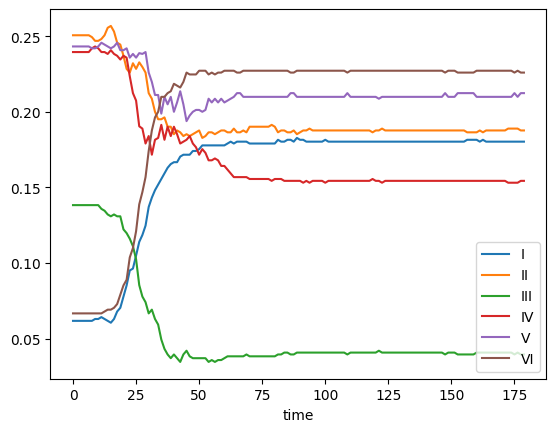

In [48]:
timeSeries = getVerticesAverage(counts)
ax = plt.gca()
types = timeSeries.columns.to_list()[1:]
for col in types:
    timeSeries.plot(kind='line',
        x='time',
        y=col,
        ax=ax
        )


In [49]:
rampSeries = timeSeries[timeSeries['time'] <= 60]
evoSeries = timeSeries[timeSeries['time'] > 60]

rampSeries["field"] = 8 * rampSeries["time"]/60
evoSeries["offtime"] = (evoSeries["time"]-60)

/tmp/ipykernel_17331/2382862370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rampSeries["field"] = 8 * rampSeries["time"]/60
/tmp/ipykernel_17331/2382862370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evoSeries["offtime"] = (evoSeries["time"]-60)


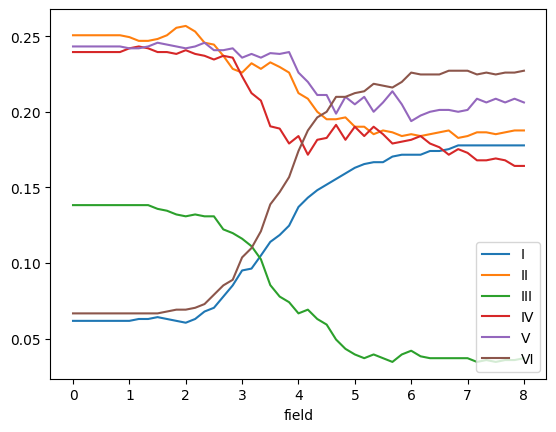

In [51]:
ax = plt.gca()
for col in types:
    rampSeries.plot(kind='line',
        x='field',
        y=col,
        ax=ax
        )

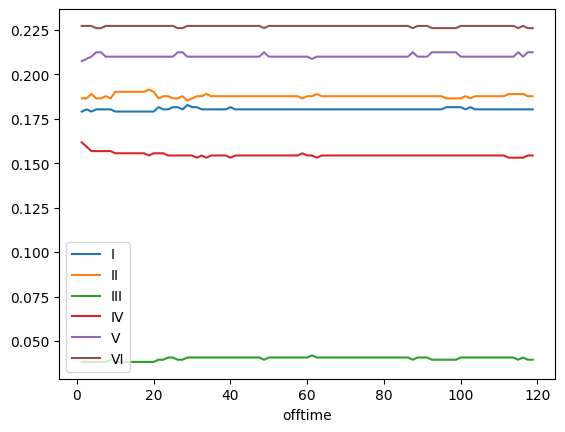

In [52]:
ax = plt.gca()
for col in types:
    evoSeries.plot(kind='line',
        x='offtime',
        y=col,
        ax=ax
        )

(<Figure size 500x500 with 1 Axes>, <Axes: >)

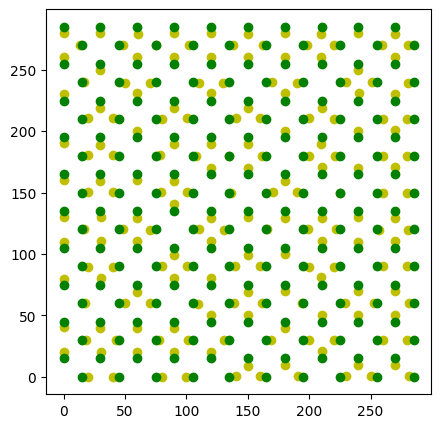

In [59]:
lastFrame = trj_raw.index.get_level_values("frame")[-1]
plotColloid(trj_raw,lastFrame)

100%|██████████| 200/200 [00:01<00:00, 163.63it/s]


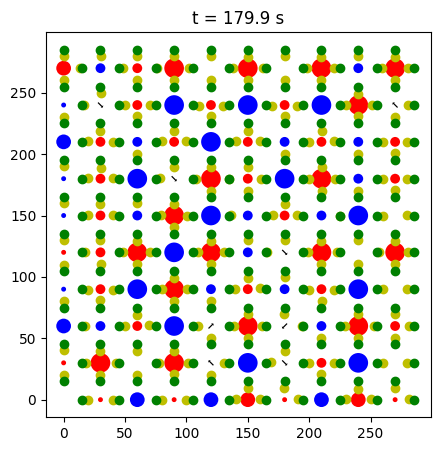

In [63]:
getPaintedFrame(trj_raw,ctrj_raw,lastFrame-1,20)

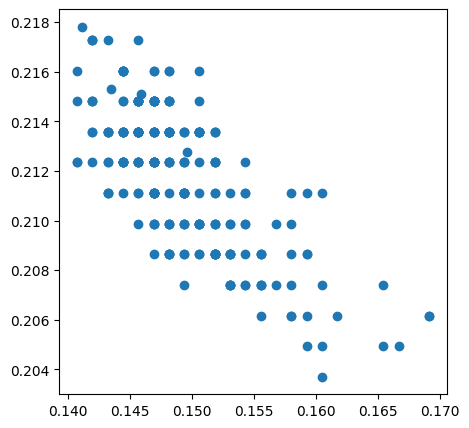

In [24]:
f,ax = plt.subplots(figsize=(5,5))
ax.scatter(type4,type5)

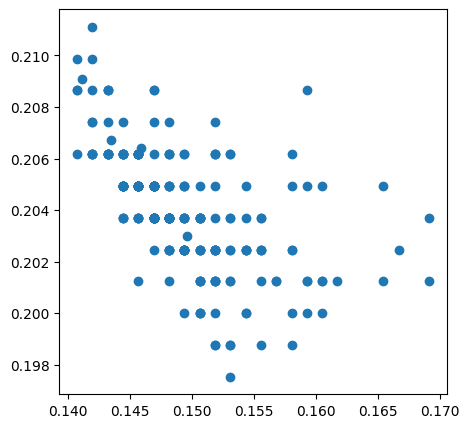

In [25]:
f,ax = plt.subplots(figsize=(5,5))
ax.scatter(type4,type2)